In [1]:
# importing dependencies
import nbimporter
import Var
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random 
import scipy.optimize
from scipy import stats 
from pandas_datareader import data as pdr
from scipy.stats import norm,binom,chi2
from scipy.linalg import cholesky
import matplotlib.pyplot as plt 
import datetime as dt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
sns.set()

## Back Testing
Testing the models for a 1-day 95% Var

In [2]:
# obtaining data for backtesting
tickers_list=['AAPL','AMZN','MSFT','GOOG']
start=dt.datetime(2013,1,1)
end=dt.datetime(2019,1,1)
data,returns,dates,meanReturns,covMatrix=Var.getData(tickers_list,start,end)
# initializing parameters
h=1
alpha=0.05
P0=10000
weights=np.random
random.seed(2802)
num=random.sample(range(1, 10), len(returns.columns))
weights=num/np.sum(num)


In [3]:
index=['eqwma','ewma','garch(1,1)','hs','mc']
#placeholder for the total number of exceedances for each model
list_models=['eqwma','ewma','garch(1,1)','hs','mc']
list_exceedances=[]
#placeholder for the series of losses for our portfolio for each model
list_losses=[]

for i in range(len(list_models)):
    obj=Var.ModelValidation(data,h,alpha,P0,weights,list_models[i],testSize=0.4)
    df,n_exceedances=obj.backTest()
    list_exceedances.append(n_exceedances)
    list_losses.append(df)

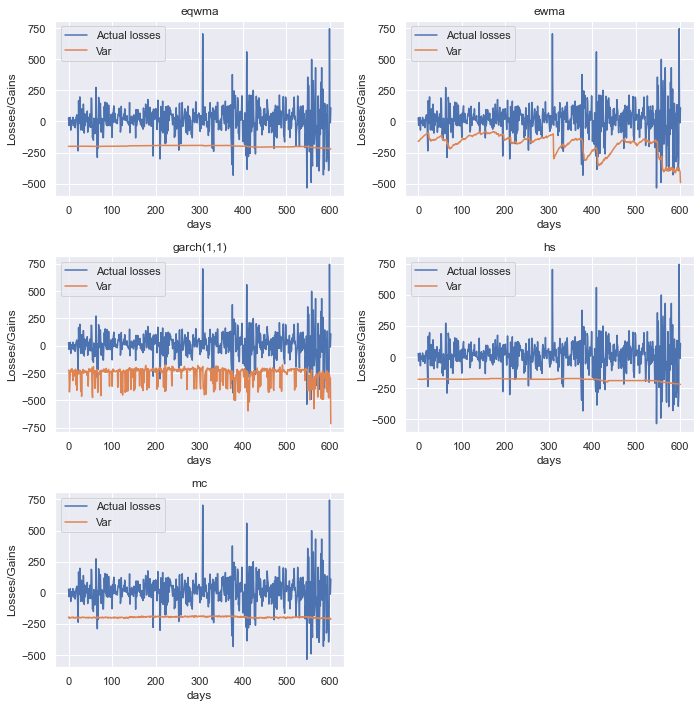

In [4]:
#plotting the actual losses and the Vars 
fig, axes = plt.subplots(3,2,figsize=(10,10))
axes=axes.flatten()
for i in range(len(list_losses)):
    df=list_losses[i]
    axes[i].plot(df.iloc[:,0],label='Actual losses')
    axes[i].plot(df.iloc[:,1],label='Var')
    axes[i].set_xlabel('days')
    axes[i].set_ylabel('Losses/Gains')
    axes[i].set_title(str(index[i]))
    axes[i].legend(loc='upper left')
plt.tight_layout()
fig.delaxes(axes[-1])


In [5]:
list_exceedances

[37, 35, 20, 41, 37]

In [6]:
print(len(list_losses[0]))

603


### Unconditional Coverage Test and Independent Test

In [7]:
obj=Var.ModelValidation(data,h,alpha,P0,weights,'eqwma')
# the significal level for the test will be the same as alpha
bin_test=[]
ind_test=[]
uct=[]
#binomial confidence interval
index=['EQWMA','EWMA','GARCH(1,1)','HS','MC']


for i in range(len(list_models)):
    df=list_losses[i]
    lower,upper=obj.exactBinomCI(alpha,df,alpha)
    if list_exceedances[i]<lower or list_exceedances[i]>upper:
        result='Reject H0: Exceedances!=expected value'
    else:
        result='Cannot reject H0: Exceedances= expected value'
    bin_test.append(result)

#independent test
for i in range(len(list_models)):
    df=list_losses[i]
    result=obj.ind_test(df,alpha)
    ind_test.append(result)
    
#unconditional coverage test
for i in range(len(list_models)):
    df=list_losses[i]
    result=obj.UCT(alpha,df,alpha)
    uct.append(result)



In [8]:
table3=pd.DataFrame(list(zip(bin_test,ind_test,uct)),\
                   columns =['Binomial CI at {}%-SL'.format(alpha*100),'Independent Test at {}% SL'.format(alpha*100),\
                            'UCT at {}% SL'.format(alpha)],index=index)


In [9]:
table3

,Binomial CI at 5.0%-SL,Independent Test at 5.0% SL,UCT at 0.05% SL
EQWMA,Cannot reject H0: Exceedances= expected value,independent,Model no well calibrated
EWMA,Cannot reject H0: Exceedances= expected value,not independent,Model no well calibrated
"GARCH(1,1)",Cannot reject H0: Exceedances= expected value,not independent,Model no well calibrated
HS,Cannot reject H0: Exceedances= expected value,independent,Model no well calibrated
MC,Cannot reject H0: Exceedances= expected value,independent,Model no well calibrated
